In [1]:
import warnings
from itertools import product

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed
from numpy.random import binomial
from scipy.stats import fisher_exact, mannwhitneyu, ttest_ind, wilcoxon

from graspy.plot import heatmap

warnings.filterwarnings("ignore")

%matplotlib inline

In [84]:
def generate_data(n_samples, p, seed):
    """
    Generate binomial data. Each col represents a different bernoulli p
    
    Parameters
    ----------
    n_samples : int
        Number of samples for each class
    p : 1d-array, shape (n_features)
        Vector of Bernoulli probability vector
        
    Returns
    -------
    pop_1 : 2d-array, shape (n_samples, n_features)
    pop_2 : 2d-array, shape (n_samples, n_features)
    """
    #np.random.seed(seed)
    rng = np.random.RandomState(seed)


    res = rng.binomial(1, p, size=(n_samples*2, p.size))
    pop_1 = res[:n_samples]
    pop_2 = res[n_samples:]
    
    return pop_1, pop_2

def compute_p_values(pop_1, pop_2, test):
    """
    Calculate the power of a given test

    Parameters
    ----------
    pop_1 : 2d-array, shape (n_samples, n_features)
    pop_2 : 2d-array, shape (n_samples, n_features)
    scipy_methods : function
        Statistical tests from scipy.stats
        Assumes function returns are of the form (statistic, p-value)

    Returns
    -------
    p_vals : np.ndarray, shape (n_features, n_features)
        All p-values generated by test
    """
    assert pop_1.shape[1] == pop_2.shape[1]
    
    n = pop_1.shape[0]
    n_cols = pop_1.shape[1]
    p_vals = np.ones(shape=(n_cols, n_cols))
    
    for u, v in product(range(n_cols), range(n_cols)):
        edge_1 = pop_1[:, u]
        edge_2 = pop_2[:, v]
    
        if test.__name__ == "fisher_exact":
            edge_1_n_zero = np.count_nonzero(edge_1)
            edge_2_n_zero = np.count_nonzero(edge_2)

            data = [
                [edge_1_n_zero, n - edge_1_n_zero],
                [edge_2_n_zero, n - edge_2_n_zero],
            ]
            _, pval = test(data)
        else:
            try:
                _, pval = test(edge_1, edge_2)
            except:
                pval = 1

        if not np.isnan(pval):
            p_vals[u, v] = pval
        
    return p_vals

def run_tests(n, epsilon=0.01, num=100, n_iter=100, scipy_tests=[], n_jobs=-10):
    """
    Parameters
    ----------
    n : int
        Number of samples in each of two classes.
    epsilon : float
        Sets the min/max value of [epsilon, 1-epsilon].
    num : int, optional
        Number of probability values to generate between [epsilon, 1-epsilon]. 
        Default is 100. Must be non-negative.
    n_iter : int, optional
        Number of iterations to compute for each test
    scipy_methods : list of functions
        Statistical tests from scipy.stats
        Assumes function returns are of the form (statistic, p-value)
    """
    p = np.linspace(0 + epsilon, 1 - epsilon, num)
    
    def worker(seed):
        pop_1, pop_2 = generate_data(n, p, seed)
        p_vals = np.ones(shape=(len(scipy_tests), p.size, p.size))
        for k, test in enumerate(scipy_tests):
            p_vals[k] = compute_p_values(pop_1, pop_2, test)
        return p_vals
    
    res = Parallel(n_jobs=n_jobs, verbose=1, backend='loky')(delayed(worker)(seed) for seed in range(n_iter))
    
    out = np.empty(shape=(len(scipy_tests), n_iter, p.size, p.size))
    for i in range(len(res)):
        out[:, i, :, :] = res[i]
        
    return out

def generate_plot(data, figure_title, titles, xaxis_label="Population 1 Probability", yaxis_label="Population 2 Probability"):
    p = np.linspace(0 + 0.01, 1 - 0.01, 99)
    tick_labels = []
    for i in range(99):
        if i % 11 == 0:
            tick_labels.append(p[i])
        else:
            #tick_labels.append(None)
            pass
    else:
        tick_labels.append(p[-1])
    tick_labels = np.array(tick_labels)

    with sns.plotting_context('talk', font_scale=1.2):
        fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
        ax = ax.ravel()

        for i in range(data.shape[0]):
            tmp = data[i]
            mean = (tmp < 0.05).mean(axis=0)
            sns.heatmap(
                mean, cbar=False, ax=ax[i], cmap='RdBu_r', center=0, square=True,
                xticklabels=tick_labels, 
                yticklabels=tick_labels[::-1], 
            )
            ax[i].set_title(titles[i])
            ax[i].set_xticks(ax[i].get_xlim()[1] * tick_labels)
            ax[i].set_yticks(ax[i].get_xlim()[1] * tick_labels[::-1])
            
        #ax[0].set_ylabel(axis_label)
        fig.text(0.5, -0.04, xaxis_label, va='center', ha='center')
        fig.text(-0.04, 0.5, yaxis_label, va='center', rotation='vertical')
            
        fig.tight_layout()
        
        fig.suptitle(figure_title, y=1.02)
        
    return fig

In [4]:
scipy_tests = [ttest_ind, mannwhitneyu, fisher_exact, wilcoxon]

In [ ]:
ns = list(range(10, 101, 10))

res = [
    run_tests(n=n, num=99, n_iter=500, scipy_tests=scipy_tests)
    for n in ns
]

np.save("data", res)

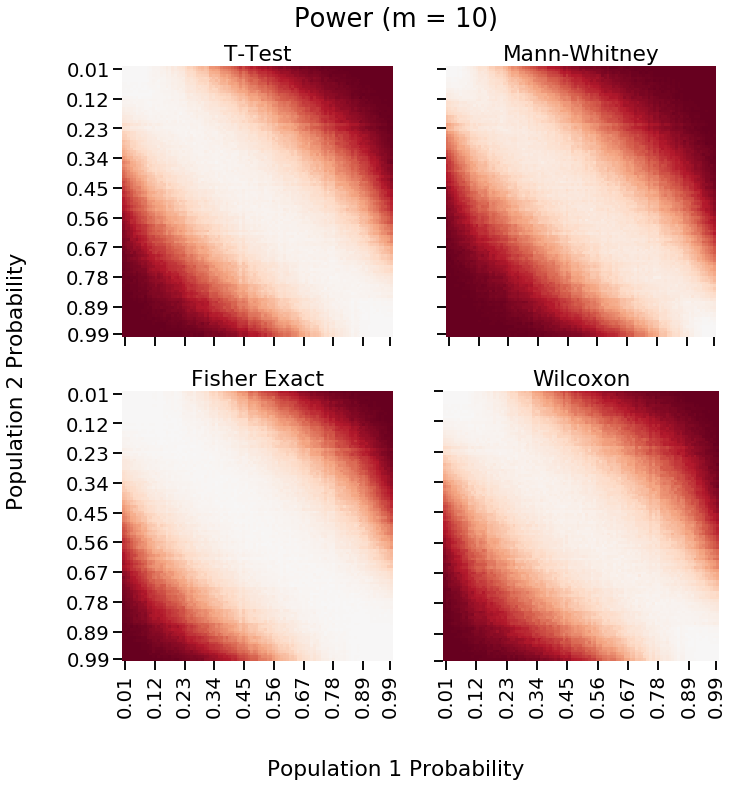

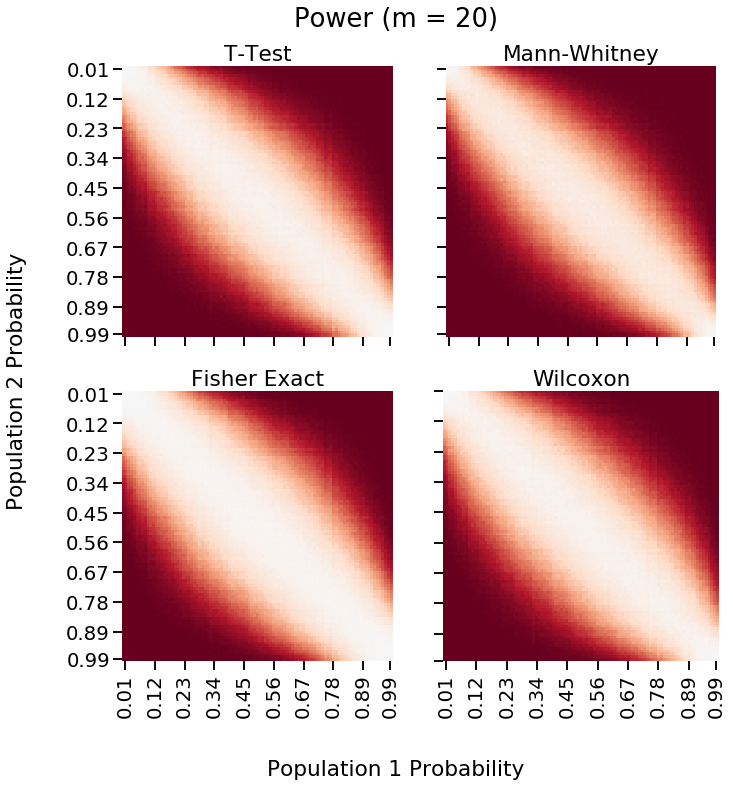

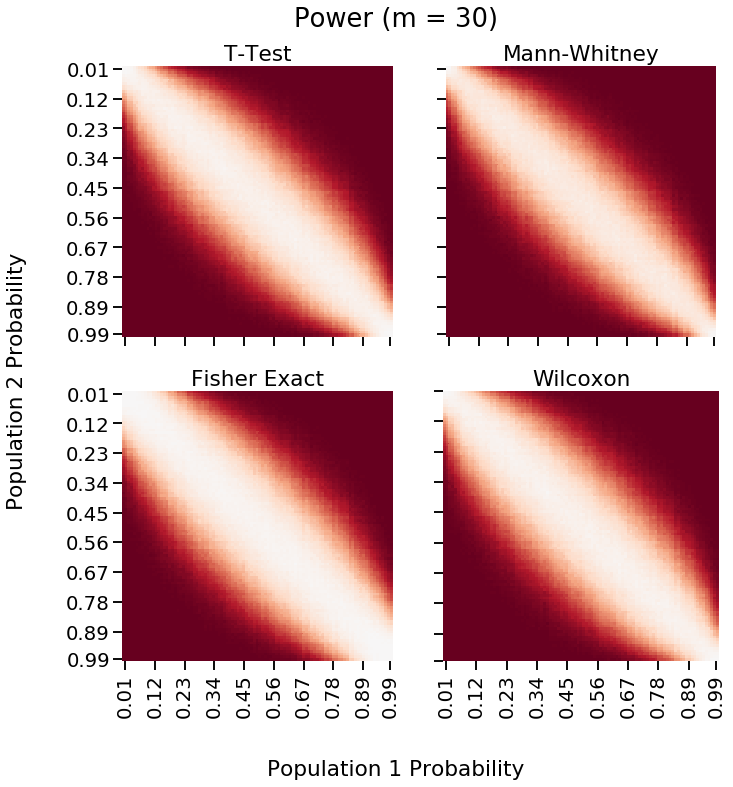

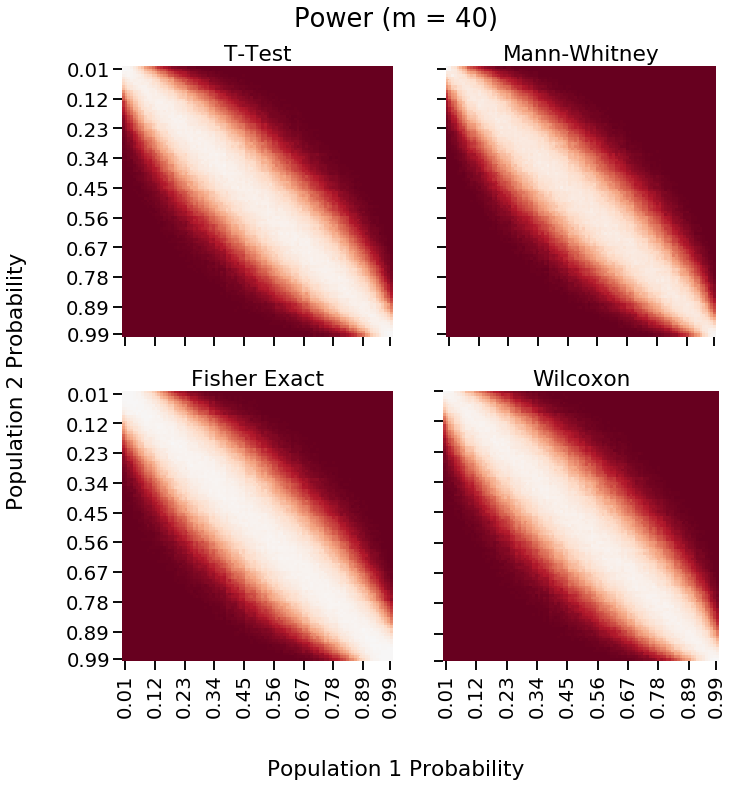

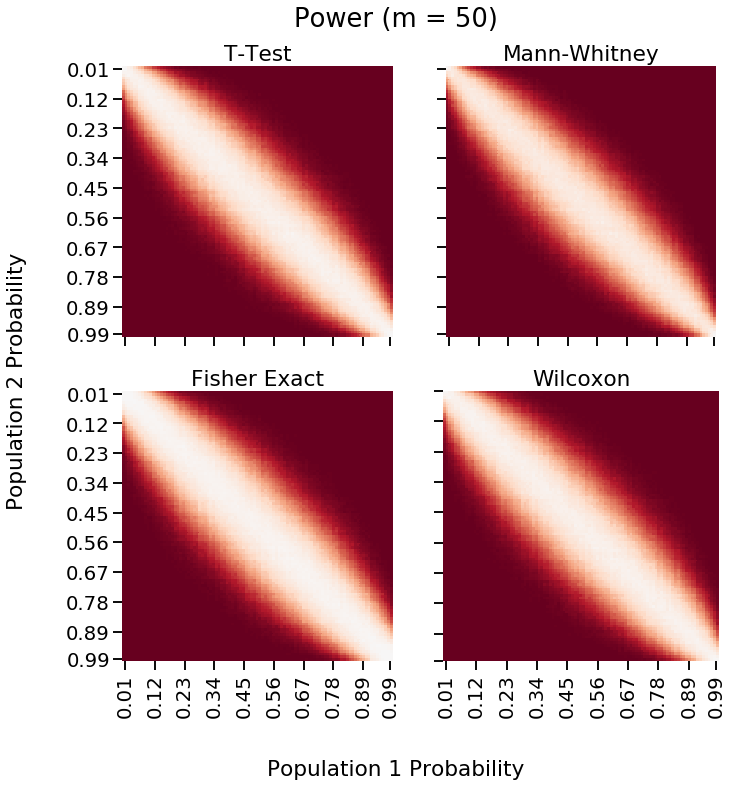

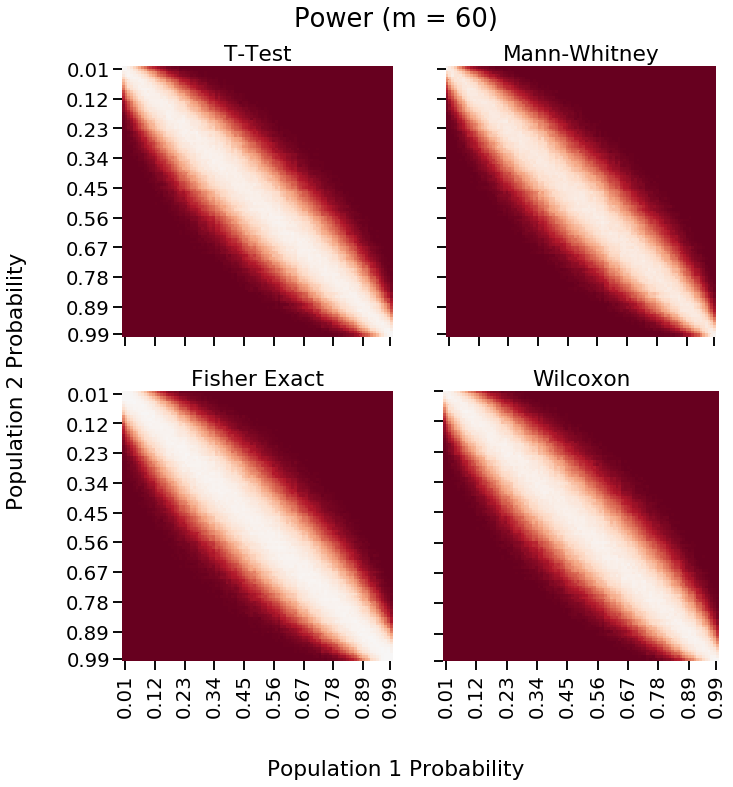

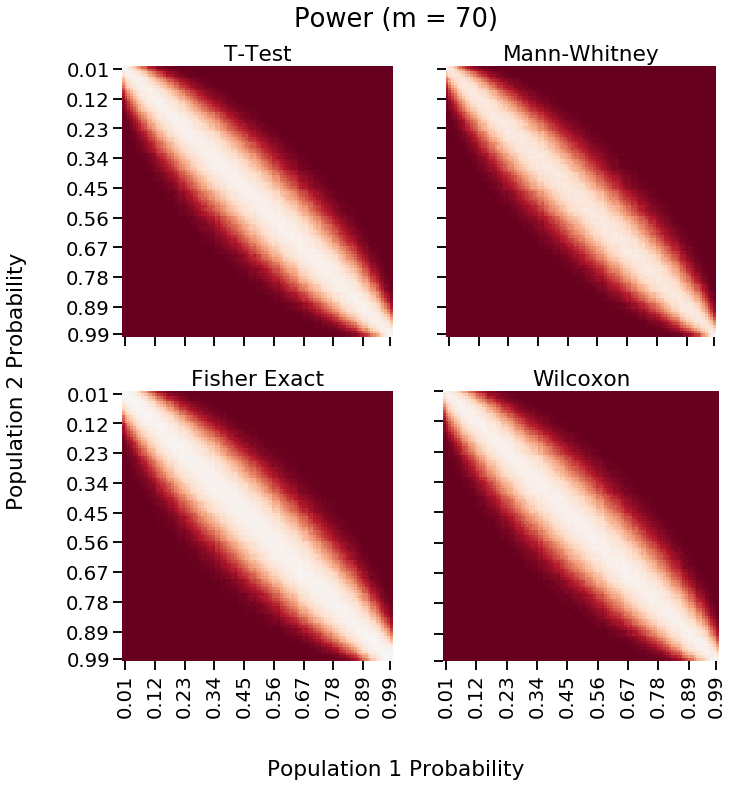

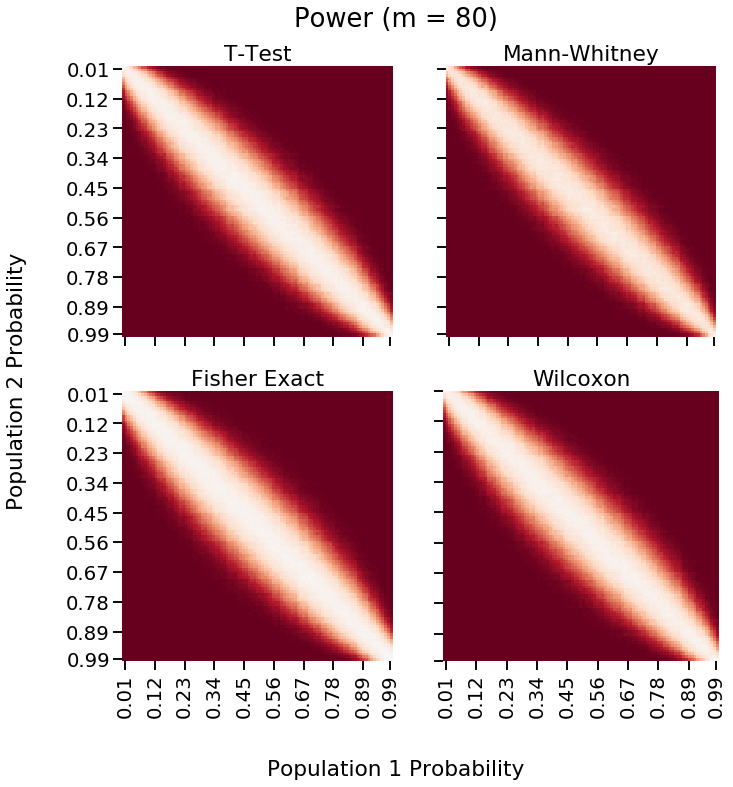

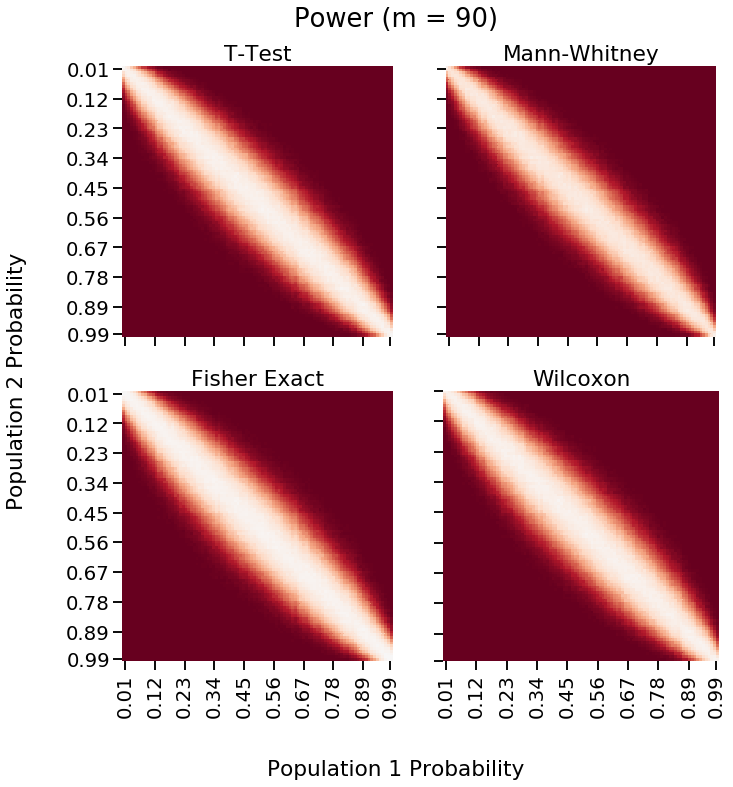

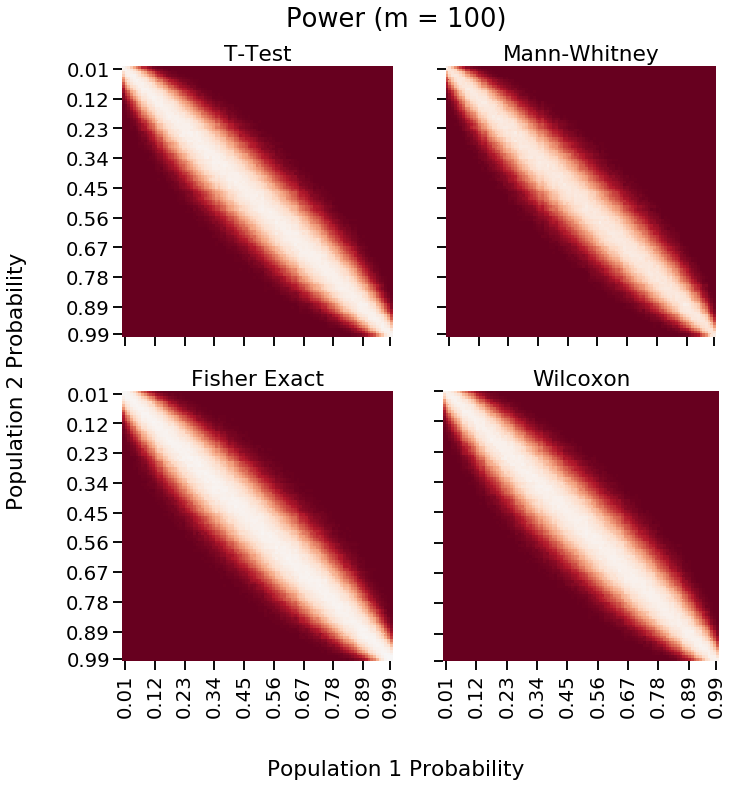

In [86]:
for i, n in enumerate(ns):
    fig = generate_plot(
        res[i], 
        f"Power (m = {n})",
        ["T-Test", "Mann-Whitney", "Fisher Exact", 'Wilcoxon'],
    )
    
    fig.savefig(f"j1c_results/power_m_{n}.pdf", bbox_inches='tight')
    fig.savefig(f"j1c_results/power_m_{n}.png", bbox_inches='tight', dpi=300)

In [89]:
def plot_power_diff(data, figure_title, xaxis_label="Population 1 Probability", yaxis_label="Population 2 Probability"):
    tmp = (data < 0.05).mean(axis=(1))
    tmp = tmp[0] - tmp[1:]
    
    titles = ["T-Test - Mann-Whitney", "T-Test - Fishers Exact", "T-Test - Wilcoxon"]

    with sns.plotting_context('talk'):
        p = np.linspace(0 + 0.01, 1 - 0.01, 99)
        tick_labels = []
        for i in range(99):
            if i % 11 == 0:
                tick_labels.append(p[i])
            else:
                #tick_labels.append(None)
                pass
        else:
            tick_labels.append(p[-1])
        tick_labels = np.array(tick_labels)

        fig, ax = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 0.05]}, figsize=(16, 5))
        for i in range(3):
            sns.heatmap(
                tmp[i], cbar=True, ax=ax[i], cmap='RdBu_r', center=0, square=True,
                xticklabels=tick_labels, 
                yticklabels=tick_labels[::-1], cbar_ax=ax[-1], vmin=-.4, vmax=.4
            )
            ax[i].set_title(titles[i])
            ax[i].set_xticks(ax[i].get_xlim()[1] * tick_labels)
            ax[i].set_yticks(ax[i].get_xlim()[1] * tick_labels[::-1])
            
            if i != 0:
                ax[i].yaxis.set_major_formatter(plt.NullFormatter())

        fig.tight_layout()
        fig.suptitle(figure_title, y = 1.1)
        
        
        fig.text(0.5, -0.05, xaxis_label, va='center', ha='center')
        fig.text(-0.01, 0.5, yaxis_label, va='center', rotation='vertical')
        
    return fig

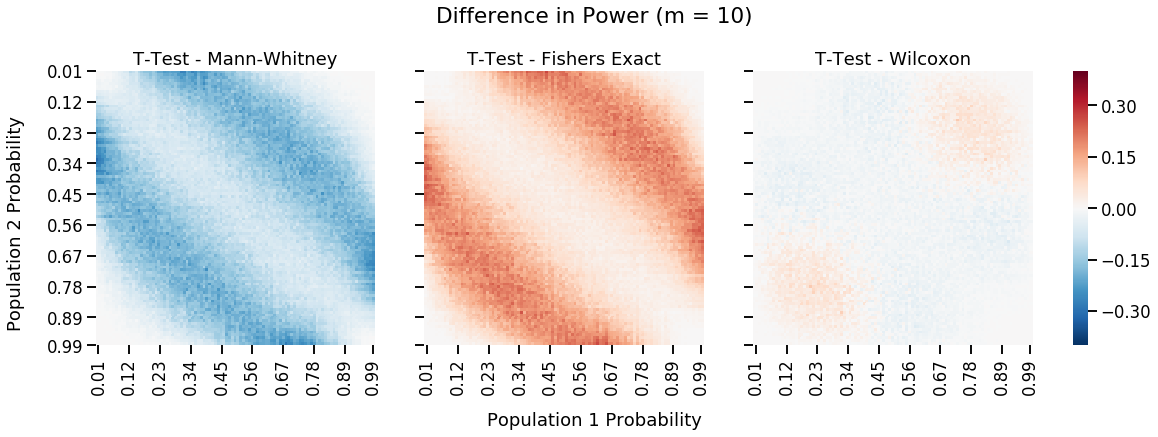

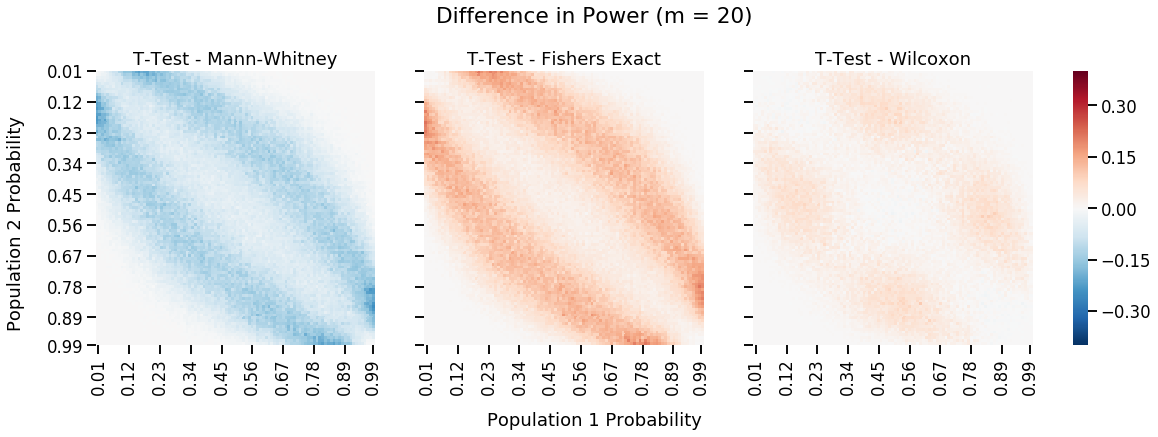

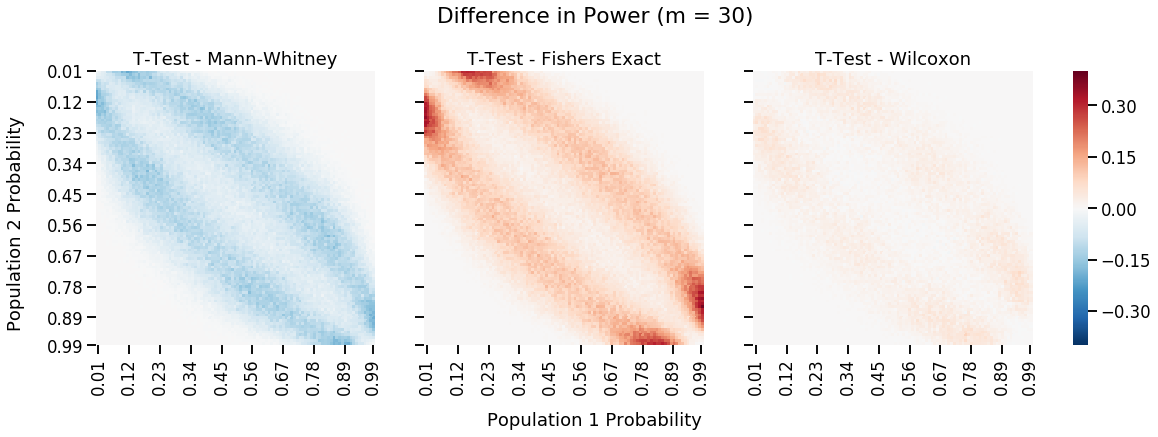

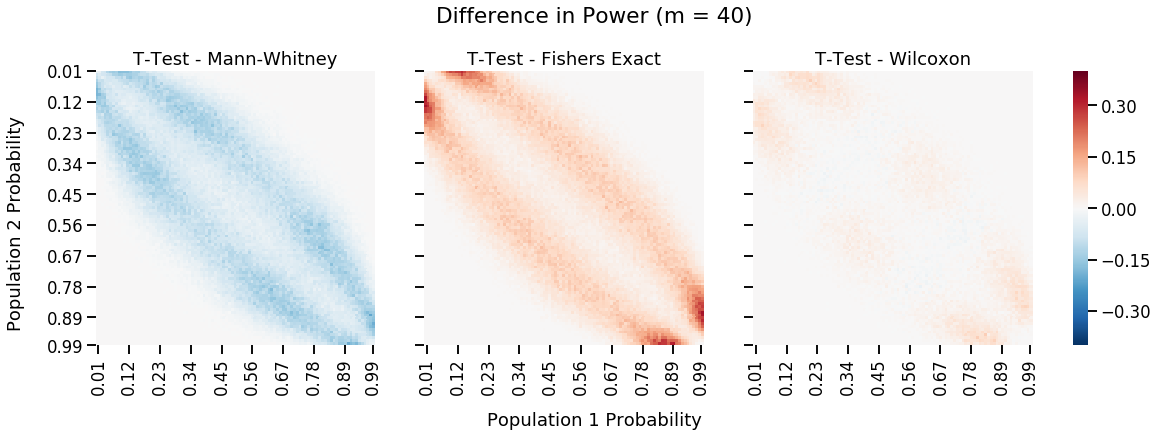

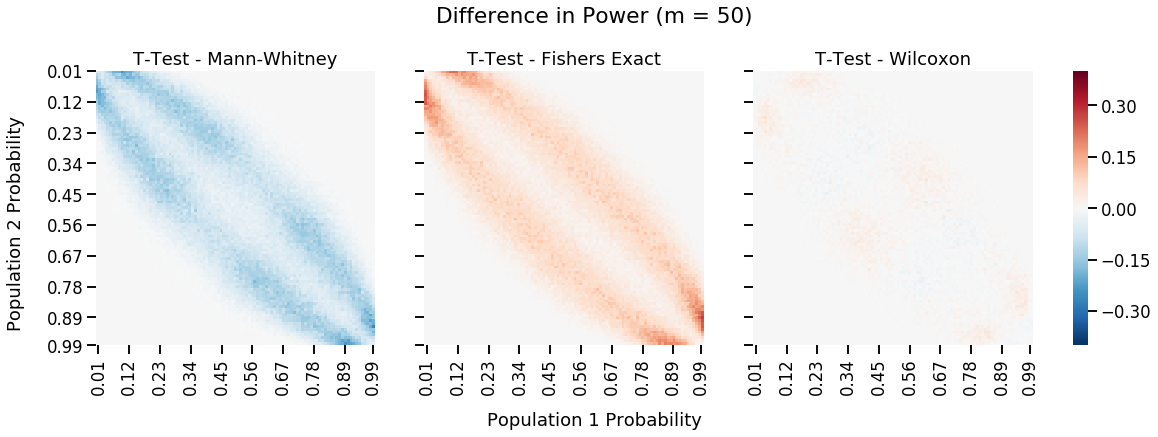

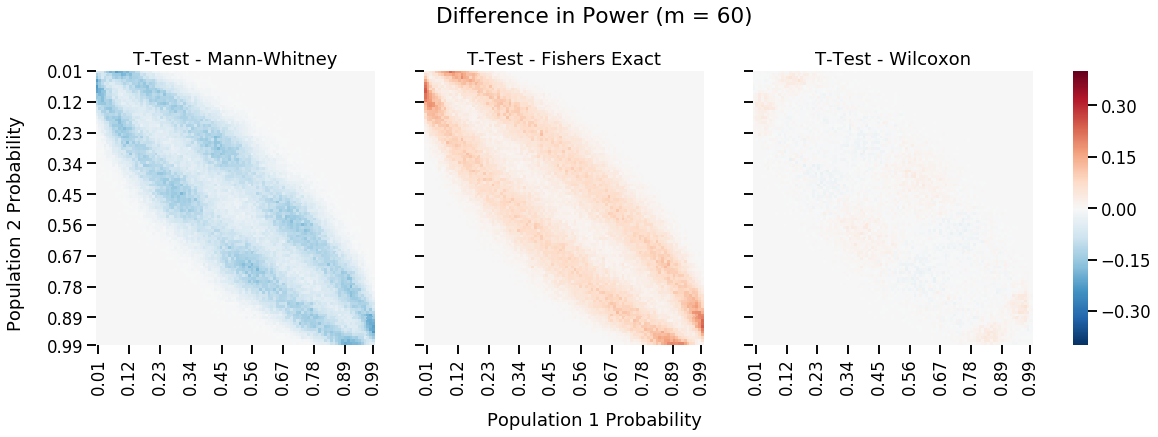

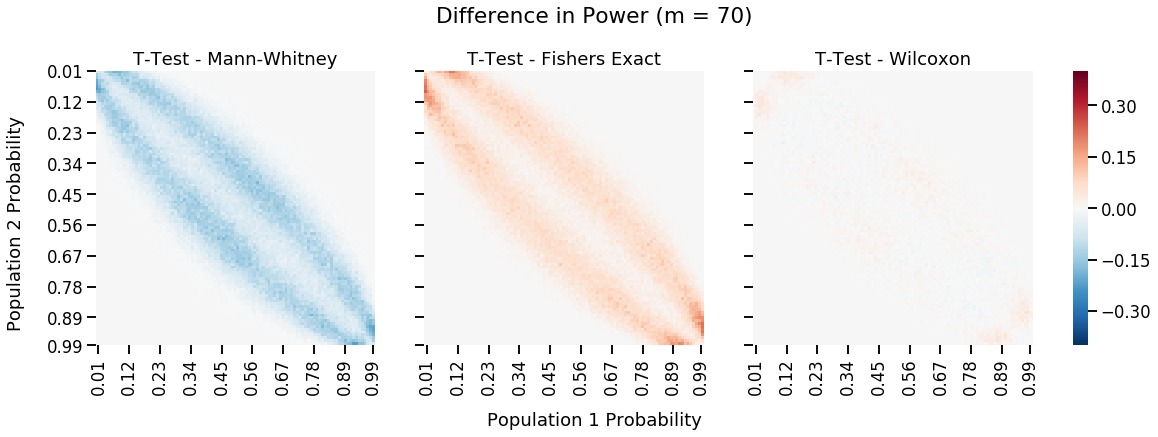

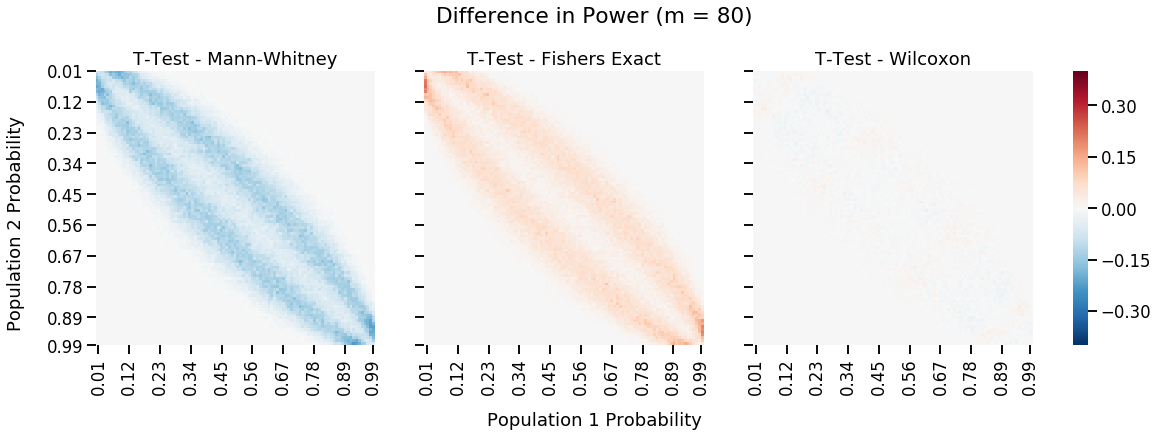

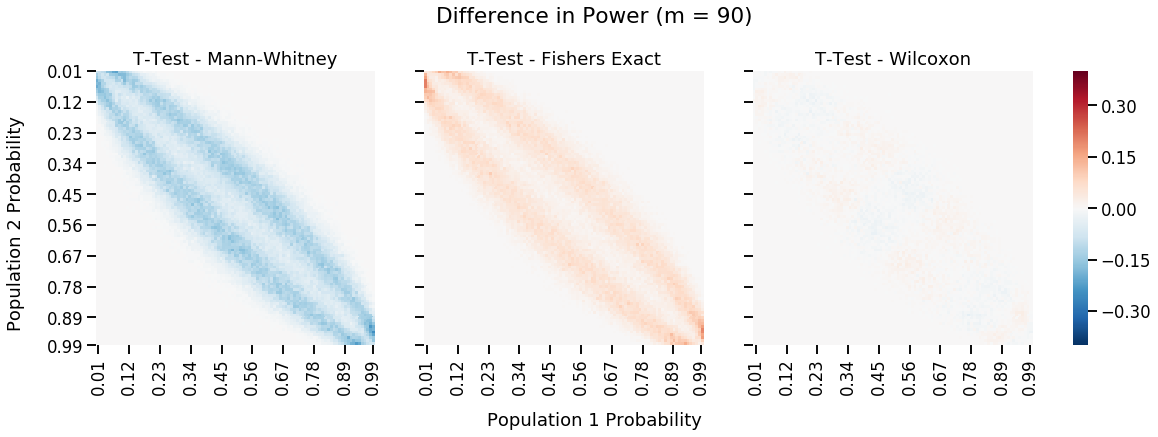

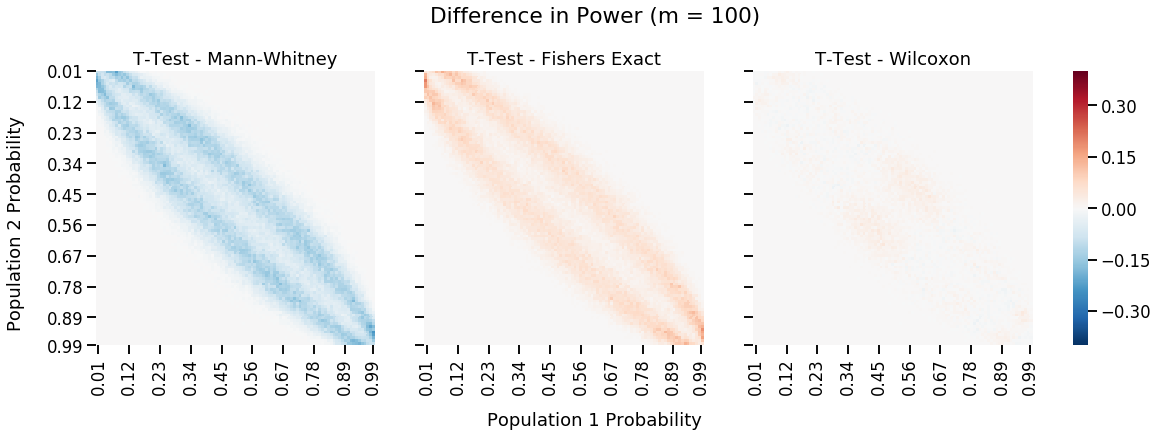

In [90]:
for i, n in enumerate(ns):
    fig = plot_power_diff(
        res[i], 
        f"Difference in Power (m = {n})",
    )
    
    fig.savefig(f"j1c_results/power_diff_m_{n}.pdf", bbox_inches='tight')
    fig.savefig(f"j1c_results/power_diff_m_{n}.png", bbox_inches='tight', dpi=300)